In [1]:
class ScratchSVMClassifier():
   
    def __init__(self, 
                 num_iter, 
                 lr, 
                 kernel_type ='linear', 
                 threshold=1e-5, 
                 sp_vector_cnt_threshold=5,
                 gamma=1, 
                 theta0=0, 
                 pow_d=1,
                 verbose=False):
        
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel_type
        self.threshold = threshold
        self.sp_vector_cnt_threshold = sp_vector_cnt_threshold
        self.verbose = verbose
        self.gamma = gamma
        self.theta0 = theta0
        self.pow_d = pow_d

    def fit(self, X, y, X_val=None, y_val=None):
        
        #train set transpose
        X = X.T
        bias = np.array([1 for _ in range(X.shape[1])])
        X = np.vstack((bias, X))
        y = y.reshape(1, len(y))

        #valid set
        if X_val is not None:
            X_val = X_val.T
            bias = np.array([1 for _ in range(X_val.shape[1])])
            X_val = np.vstack((bias, X_val))
            y_val = y_val.reshape(1, len(y_val))


        self.num_of_feature = X.shape[0]
        self.num_of_samples = X.shape[1]

        y = np.where(y>0, 1, -1)
        if X_val is not None:
            y_val = np.where(y_val>0, 1, -1)
        
        train_data = np.concatenate((X, y), axis=0)
        SP_LABEL_CNT_THRESHOLD = int(self.sp_vector_cnt_threshold / 2)

        ##create lambda for each observation
        LAMBDA_INIT_MIN = 1
        LAMBDA_INIT_MAX = 10
        LAMBDA_INIT_SCALE = 1e-07
        self.lam = np.random.randint(LAMBDA_INIT_MIN, LAMBDA_INIT_MAX, X.shape[1]) * LAMBDA_INIT_SCALE
        self.lam = np.reshape(self.lam, (1, len(self.lam)))

        #training 
        for i in range(0, self.iter):
            self.lam = self._gradient_descent(X, y)
            if self.sp_vector_cnt_threshold <= np.sum(self.lam > self.threshold):
                selector = self.lam * np.ones((train_data.shape[0], 1))
                sp_vector = train_data[selector > self.threshold]
                sp_vector = sp_vector.reshape(train_data.shape[0], (int)(len(sp_vector) / train_data.shape[0]))
                label_p_cnt = np.sum([sp_vector[sp_vector.shape[0] - 1] == 1])
                label_n_cnt = np.sum([sp_vector[sp_vector.shape[0] - 1] == -1])
               
                if label_p_cnt >= SP_LABEL_CNT_THRESHOLD & label_n_cnt >= SP_LABEL_CNT_THRESHOLD:
                    self.sp_vector = sp_vector
                    self.lam = self.lam[self.lam > self.threshold]
                    break


        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()


    def predict(self, X):
        
        X = X.T
        bias = np.array([1 for _ in range(X.shape[1])])
        X = np.vstack((bias, X))

        #create support vectors
        x_sn = self.sp_vector[0:self.sp_vector.shape[0] - 1]
        x_sn = x_sn.reshape((self.num_of_feature, x_sn.shape[1]))
        y_sn = self.sp_vector[self.sp_vector.shape[0] - 1].reshape((1, x_sn.shape[1]))
   
        lam = self.lam
        tmp1 = self._svm_kernel_function(X, x_sn)
    
        tmp2 = lam * y_sn * tmp1
        pred = np.sum(tmp2, axis=1)
        pred[pred < 0] = -1
        pred[pred >= 0] = 1
        pred = pred.astype('int8').T
        
        return np.where(pred==-1, 0, 1)

    def _svm_kernel_function(self, X1, X2):
    
        if self.kernel == 'linear':
            out = np.dot(X1.T, X2)
        elif self.kernel == 'rbf':
            out = self.gamma * (np.dot(X1.T, X2) + self.theta0)**self.pow_d
        else:
            out = 0

        return out

    def _gradient_descent(self, X, y):
        
        tmp1 = y.T * y * self.lam * self._svm_kernel_function(X, X)
        delta = 1 - (np.sum(tmp1, axis=0))
        delta = delta.reshape(len(delta), 1)
        res = self.lam + self.lr * delta.T
        res[res < 0] = 0

        return res
        
    def plot_boundary(self, feature, target, index_of_x1, index_of_x2):
        
        x_sn = self.sp_vector[0:self.sp_vector.shape[0] - 1]
        x_sn = x_sn.reshape((self.num_of_feature, x_sn.shape[1]))
        y_sn = self.sp_vector[self.sp_vector.shape[0] - 1].reshape((1, x_sn.shape[1]))
        sp_theta = self.lam * y_sn * x_sn
        sp_theta = np.sum(sp_theta, axis=1)
        b = sp_theta[0]
    
        y = -1 * (b + sp_theta[index_of_x1]) / sp_theta[index_of_x2] * feature[:, index_of_x1]
        plt.title("Boundary")
        plt.xlabel("Feature index={}".format(index_of_x1))
        plt.ylabel("Feature index={}".format(index_of_x2))
        plt.plot(feature[:, index_of_x1], y, label="Boundary")
        plt.scatter(feature[:, index_of_x1], feature[:, index_of_x2], c=target)
        plt.show()

    def get_sp_vectors(self):
        return self.sp_vector

In [2]:
import numpy as np

test

In [3]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler

X, y = datasets.make_blobs(n_samples=200, n_features=2, centers=2, 
                           cluster_std=1.05, random_state=40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [4]:
clf = ScratchSVMClassifier(num_iter=200, lr=0.05, threshold=0.01, kernel_type='rbf')
clf.fit(X_train, y_train)

In [5]:
X_test.shape

(40, 2)

In [6]:
pred = clf.predict(X_test)
pred

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0])

Decision Boundry

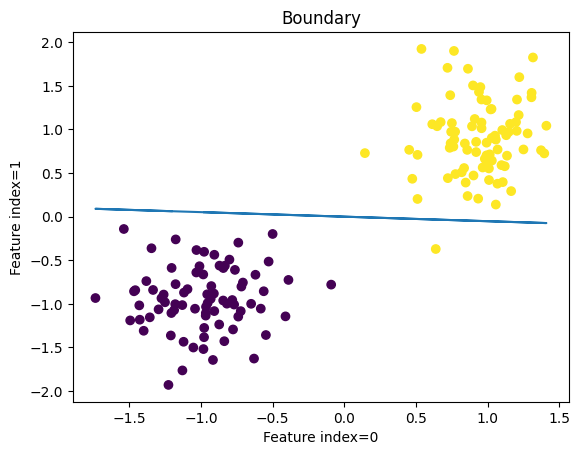

In [7]:
clf.plot_boundary(X_train, y_train, 0, 1)

In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.scatter(model.sp_vector[1], model.sp_vector[2], s=80, color='yellow')
    plt.legend(handles=patches)
    plt.legend()
    plt.show()